 # Train and test PPO-based electric motor controller

The objective of this project is to train a controller/a RL agent for the current control of a permanent magnet synchronous motor (PMSM). The agent controls the converter that converts the supply currents to the currents flowing into the motor - for the PMSM: $i_{sg}$ and $i_{sd}$. This jupyter notebook is based on [gym-electric-motor](https://github.com/upb-lea/gym-electric-motor/tree/master) Github repo.

![SCML](SCML_Overview.png)


In the continuous case, the agent's action equals a duty cycle which will be modulated into a corresponding voltage.

In the discrete case, the agent's actions denote switching states of the converter at the given instant. In this notebook, for the PMSM the discrete B6 bridge converter with six switches is utilized per default. This converter provides a total of eight possible actions.

The target for the agent is now to learn to control the currents. For this, a reference generator produces a trajectory that the agent has to follow. Therefore, it has to learn a function (policy) from given states, references and rewards to appropriate actions.

Check for more inforamtion about [gym-electric-motor(GEM)](https://upb-lea.github.io/gym-electric-motor/) and [Towards a Reinforcement Learning Environment Toolbox for Intelligent Electric Motor Control](https://arxiv.org/abs/1910.09434).

<b>Requirements</b>

stable-baselines3
<br> gym-electric-motor

### Import used libraries and modules

In [1]:
import numpy as np
import gym_electric_motor as gem
from gym_electric_motor.visualization import MotorDashboard
from gym_electric_motor.core import Callback
from gym.spaces import Discrete, Box
from gym.wrappers import FlattenObservation, TimeLimit
from gym import ObservationWrapper

from stable_baselines3 import PPO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Logs the reward accumulated in each episode

In [2]:
class RewardLogger(Callback):
    def __init__(self):
        self.step_rewards = []
        self.mean_episode_rewards = []
        
    def on_step_end(self, k, state, reference, reward, done):
        """Stores the received reward at each step"""
        self.step_rewards.append(reward)
    
    def on_reset_begin(self):
        """Stores the mean reward received in every episode"""
        if len(self.step_rewards) > 0:
            self.mean_episode_rewards.append(np.mean(self.step_rewards))
        self.step_rewards = []
        
    def on_close(self):
        """Writes the mean episode reward of the experiment to a file."""
        np.save(self.fpath, np.array(self.mean_episode_rewards))

### Wrapper class

Wrapper class which wraps the environment to change its observation. Serves
the purpose to improve the agent's learning speed.

It changes epsilon to cos(epsilon) and sin(epsilon). This serves the purpose
to have the angles -pi and pi close to each other numerically without losing
any information on the angle.

Additionally, this wrapper adds a new observation $i_{sd}^2 + i_{sq}^2$. This should
help the agent to easier detect incoming limit violations.

In [3]:
class FeatureWrapper(ObservationWrapper):
    def __init__(self, env, epsilon_idx, i_sd_idx, i_sq_idx):
        """
        Changes the observation space to fit the new features
        
        Args:
            env(GEM env): GEM environment to wrap
            epsilon_idx(integer): Epsilon's index in the observation array
            i_sd_idx(integer): I_sd's index in the observation array
            i_sq_idx(integer): I_sq's index in the observation array
        """
        super(FeatureWrapper, self).__init__(env)
        self.EPSILON_IDX = epsilon_idx
        self.I_SQ_IDX = i_sq_idx
        self.I_SD_IDX = i_sd_idx
        new_low = np.concatenate((self.env.observation_space.low[
                                  :self.EPSILON_IDX], np.array([-1.]),
                                  self.env.observation_space.low[
                                  self.EPSILON_IDX:], np.array([0.])))
        new_high = np.concatenate((self.env.observation_space.high[
                                   :self.EPSILON_IDX], np.array([1.]),
                                   self.env.observation_space.high[
                                   self.EPSILON_IDX:],np.array([1.])))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation. Adds the new features to the
        observation and removes original epsilon.
        
        """
        cos_eps = np.cos(observation[self.EPSILON_IDX] * np.pi)
        sin_eps = np.sin(observation[self.EPSILON_IDX] * np.pi)
        currents_squared = observation[self.I_SQ_IDX]**2 + observation[self.I_SD_IDX]**2
        observation = np.concatenate((observation[:self.EPSILON_IDX],
                                      np.array([cos_eps, sin_eps]),
                                      observation[self.EPSILON_IDX + 1:],
                                      np.array([currents_squared])))
        return observation

### define motor arguments

In [4]:
# Define motor parameters
motor_parameter = dict(
    p=3,  # [p] = 1, nb of pole pairs
    r_s=17.932e-3,  # [r_s] = Ohm, stator resistance
    l_d=0.37e-3,  # [l_d] = H, d-axis inductance
    l_q=1.2e-3,  # [l_q] = H, q-axis inductance
    psi_p=65.65e-3,  # [psi_p] = Vs, magnetic flux of the permanent magnet
)
# Supply voltage
u_supply = 350

# Nominal and absolute state limitations
nominal_values=dict(
    omega=4000*2*np.pi/60,
    i=230,
    u=u_supply
)
limit_values=dict(
    omega=4000*2*np.pi/60,
    i=1.5*230,
    u=u_supply
)

# Sampling interval
tau = 1e-5

# Define maximal episode steps
max_eps_steps = 100

# Define motor initialisation
motor_initializer={'random_init': 'uniform', 'interval': [[-230, 230], [-230, 230], [-np.pi, np.pi]]}

# Define reward function
reward_function=gem.reward_functions.WeightedSumOfErrors(
    reward_weights={'i_sq': 10, 'i_sd': 10},
    gamma=0.99,  # discount rate 
    reward_power=1
)
# Define callbacks
reward_logger = RewardLogger()
motor_dashboard = MotorDashboard(state_plots=['i_sq', 'i_sd'], reward_plot=True)

### Creating gem environment

In [5]:
env = gem.make(  # define a PMSM with discrete action space
    "Finite-CC-PMSM-v0",
    # visualize the results
    visualization=motor_dashboard,
    
    # parameterize the PMSM and update limitations
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=motor_initializer,
    ),
    # define the random initialisation for load and motor
    load=dict(
        load_initializer={'random_init': 'uniform', },
    ),
    reward_function=reward_function,
    supply=dict(u_nominal=u_supply),
    # define the duration of one sampling step
    tau=tau,
    callbacks=(reward_logger,),
    ode_solver='euler',
)

# remove one action from the action space to help the agent speed up its training
# this can be done as both switchting states (1,1,1) and (-1,-1,-1) - which are encoded
# by action 0 and 7 - both lead to the same zero voltage vector in alpha/beta-coordinates
env.action_space = Discrete(7)

# applying wrappers
eps_idx = env.physical_system.state_names.index('epsilon')
i_sd_idx = env.physical_system.state_names.index('i_sd')
i_sq_idx = env.physical_system.state_names.index('i_sq')
env = TimeLimit(
    FeatureWrapper(
        FlattenObservation(env), 
        eps_idx, i_sd_idx, i_sq_idx
    ),
    max_eps_steps
)

### Instantiate PPO agent and train the model

In [6]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, progress_bar=True)

Output()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 89.7     |
|    ep_rew_mean     | -929     |
| time/              |          |
|    fps             | 437      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 84.4       |
|    ep_rew_mean          | -1.02e+03  |
| time/                   |            |
|    fps                  | 319        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00298807 |
|    clip_fraction        | 0.000928   |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.94      |
|    explained_variance   | -0.000167  |
|    learning_rate        | 0.0003     |
|    loss                 | 8.22e+04   |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00726   |
|    value_loss           | 1.13e+05   |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 85.5         |
|    ep_rew_mean          | -989         |
| time/                   |              |
|    fps                  | 291          |
|    iterations           | 3            |
|    time_elapsed         | 21           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0008430715 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.00176      |
|    learning_rate        | 0.0003       |
|    loss                 | 8.32e+04     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.00292     |
|    value_loss           | 1.79e+05     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 85.6         |
|    ep_rew_mean          | -960         |
| time/                   |              |
|    fps                  | 280          |
|    iterations           | 4            |
|    time_elapsed         | 29           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0018996764 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.000324     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.95e+04     |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00435     |
|    value_loss           | 1.1e+05      |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 84.2         |
|    ep_rew_mean          | -979         |
| time/                   |              |
|    fps                  | 278          |
|    iterations           | 5            |
|    time_elapsed         | 36           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0021193514 |
|    clip_fraction        | 0.002        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.000348     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.11e+04     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00625     |
|    value_loss           | 1.07e+05     |
------------------------------------------


<b>Explanation of logger output</b>

rollout/
* ep_len_mean: Mean episode length
* ep_rew_mean: Mean episodic training reward

time/
* fps: Number of frames per seconds
* time_elapsed: Time in seconds since the beginning of training
* total_timesteps: Total number of timesteps (steps in the environments)

train/
* approx_kl: approximate mean KL divergence between old and new policy (for PPO), it is an estimation of how much changes happened in the update
* clip_fraction: mean fraction of surrogate loss that was clipped (above clip_range threshold) for PPO.
* clip_range: Current value of the clipping factor for the surrogate loss of PPO
* entropy_loss: Mean value of the entropy loss (negative of the average policy entropy)
* explained_variance: Fraction of the return variance explained by the value function
* learning_rate: Current learning rate value
* loss: Current total loss value
* n_updates: Number of gradient updates applied so far
* policy_gradient_loss: Current value of the policy gradient loss (its value does not have much meaning)
* value_loss: Current value for the value function loss for on-policy algorithms

### Plot mean reward per episode

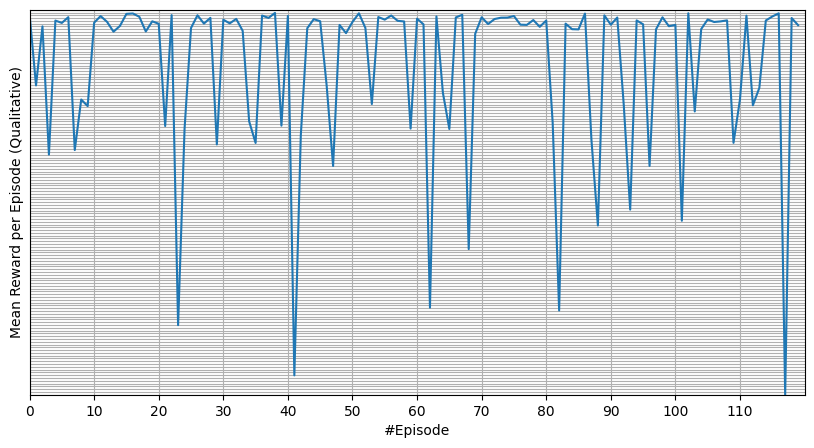

In [7]:
rewards = reward_logger.mean_episode_rewards # training rewards
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.xlim(0,len(rewards))
plt.ylim(min(rewards), 0)
plt.yticks(np.arange(min(rewards), 1, 1.0))
plt.tick_params(axis = 'y', left = False, labelleft = False)
plt.xticks(np.arange(0, len(rewards), 10))
plt.xlabel('#Episode')
plt.ylabel('Mean Reward per Episode (Qualitative)')
plt.plot(rewards)
plt.show()

### Show the motor dashboard

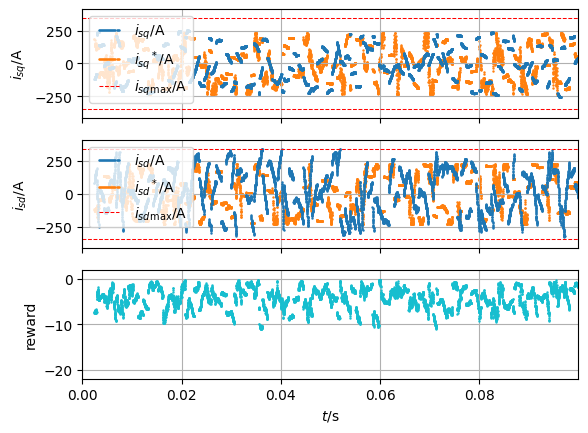

In [8]:
motor_dashboard.initialize()